In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import xgboost as xgb

In [2]:
data = pd.read_csv('train.csv')
data.head(n=100)

,Id,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel,Usage
0,617,31,120,60,6.1,98.0,76,0,Train
1,774,23,120,90,7.8,98.0,60,1,Train
2,610,13,90,65,7.5,101.0,80,2,Train
3,525,42,120,80,7.5,98.0,70,0,Train
4,70,26,85,60,6.0,101.0,86,1,Train
...,...,...,...,...,...,...,...,...,...
95,106,50,140,90,15.0,98.0,90,2,Train
96,889,15,120,80,6.8,98.0,70,0,Train
97,817,40,120,95,11.0,98.0,80,1,Train
98,271,21,120,80,7.0,98.0,77,0,Train


In [3]:
data.describe()

,Id,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,499.118372,29.912454,113.104809,76.290999,8.655758,98.663379,74.115906,0.866831
std,291.507683,13.505316,18.435744,13.798968,3.204997,1.372851,8.276928,0.807081
min,0.000000,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,0.000000
25%,251.000000,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,499.000000,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,745.500000,38.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000
max,1012.000000,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


In [4]:
data.columns

Index(['Id', 'Age', 'SystolicBP', 'DiastolicBP', 'Blood glucose', 'BodyTemp',
       'HeartRate', 'RiskLevel', 'Usage'],
      dtype='object')

In [5]:
data.isna().sum()

Id               0
Age              0
SystolicBP       0
DiastolicBP      0
Blood glucose    0
BodyTemp         0
HeartRate        0
RiskLevel        0
Usage            0
dtype: int64

In [6]:
data['RiskLevel'].value_counts()

RiskLevel
0    325
1    269
2    217
Name: count, dtype: int64

# Feature Engineering

In [7]:
data['Pulse Pressure'] = data['SystolicBP'] - data['DiastolicBP'] # Calculate Pulse Pressure
data['MAP'] = data['DiastolicBP'] + (data['Pulse Pressure']/3) # Calculate Mean Arterial Pressure

In [8]:
data['BPC'] = 'Normal'
data.loc[(data['SystolicBP'] >= 140) & (data['SystolicBP'] < 160) & (data['DiastolicBP'] >= 90) & (data['DiastolicBP'] < 110), 'BPC'] = 'Mild Hypertension'
data.loc[(data['SystolicBP'] >= 160) | (data['DiastolicBP'] >= 110), 'BPC'] = 'Severe Hypertension'
data['BPC'].value_counts()

BPC
Normal                 719
Mild Hypertension       86
Severe Hypertension      6
Name: count, dtype: int64

In [9]:
# Heart Rate Categories for Pregnant Women
data['HR_Category'] = 'Normal'
data.loc[data['HeartRate'] < 60, 'HR_Category'] = 'Bradycardia'
data.loc[(data['HeartRate'] >= 100) & (data['HeartRate'] <= 120), 'HR_Category'] = 'Mild Tachycardia' 
data.loc[data['HeartRate'] > 120, 'HR_Category'] = 'Severe Tachycardia'
data['HR_Category'].value_counts()

HR_Category
Normal         809
Bradycardia      2
Name: count, dtype: int64

In [10]:
data['Fever'] = (data['BodyTemp'] >= 100.4).astype(int)
data['Age Group'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'Adult', 'Middle-Aged', 'Senior'])
data.head(n=100)

,Id,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel,Usage,Pulse Pressure,MAP,BPC,HR_Category,Fever,Age Group
0,617,31,120,60,6.1,98.0,76,0,Train,60,80.000000,Normal,Normal,0,Adult
1,774,23,120,90,7.8,98.0,60,1,Train,30,100.000000,Normal,Normal,0,Adult
2,610,13,90,65,7.5,101.0,80,2,Train,25,73.333333,Normal,Normal,1,Teen
3,525,42,120,80,7.5,98.0,70,0,Train,40,93.333333,Normal,Normal,0,Middle-Aged
4,70,26,85,60,6.0,101.0,86,1,Train,25,68.333333,Normal,Normal,1,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,106,50,140,90,15.0,98.0,90,2,Train,50,106.666667,Mild Hypertension,Normal,0,Middle-Aged
96,889,15,120,80,6.8,98.0,70,0,Train,40,93.333333,Normal,Normal,0,Teen
97,817,40,120,95,11.0,98.0,80,1,Train,25,103.333333,Normal,Normal,0,Middle-Aged
98,271,21,120,80,7.0,98.0,77,0,Train,40,93.333333,Normal,Normal,0,Adult


In [11]:
data.dtypes

Id                   int64
Age                  int64
SystolicBP           int64
DiastolicBP          int64
Blood glucose      float64
BodyTemp           float64
HeartRate            int64
RiskLevel            int64
Usage               object
Pulse Pressure       int64
MAP                float64
BPC                 object
HR_Category         object
Fever                int64
Age Group         category
dtype: object

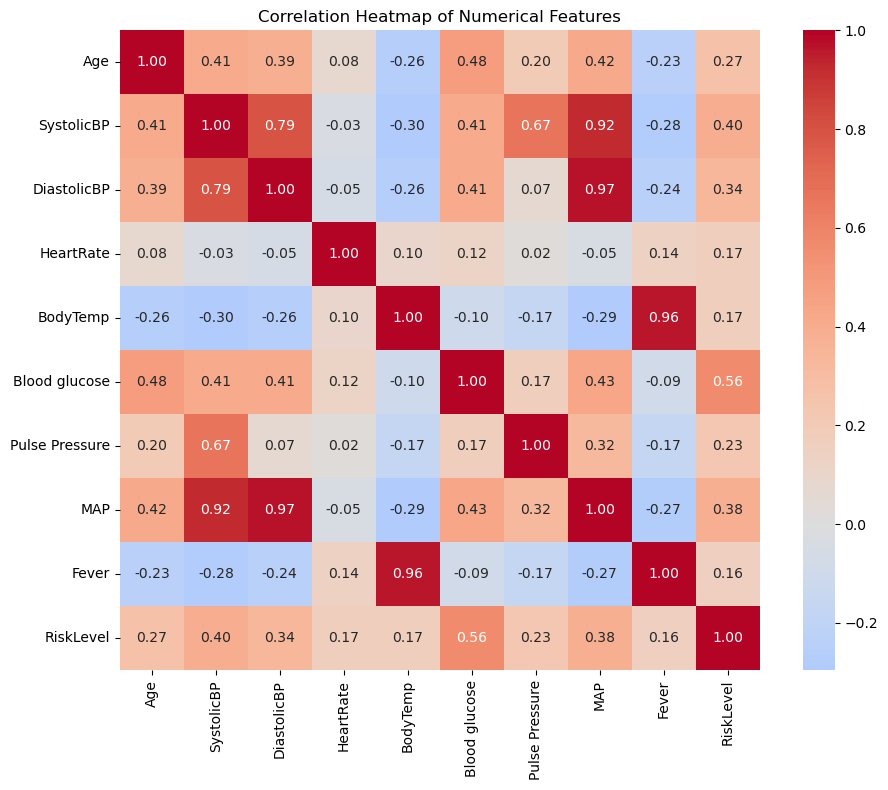

In [12]:
num_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate', 'BodyTemp', 'Blood glucose', 'Pulse Pressure', 'MAP', 'Fever', 'RiskLevel']
corr_matrix = data[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            fmt='.2f')            # Format numbers to 2 decimal places

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [13]:
data = data.drop('Fever', axis=1)  # Drop Fever column as it is not needed for further analysis

# Data Preprocessing

In [14]:
categorical_cols = ['BPC', 'HR_Category', 'Age Group']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Initialize OneHotEncoder
encoded_features = encoder.fit_transform(data[categorical_cols])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)
data_encoded = pd.concat([data.drop(categorical_cols, axis=1), encoded_data], axis=1)
data_encoded.drop(['Usage', 'Id'], axis=1, inplace=True)  # Drop 'Usage' column
data_encoded.head(n=100)

,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel,Pulse Pressure,MAP,BPC_Normal,BPC_Severe Hypertension,HR_Category_Normal,Age Group_Child,Age Group_Middle-Aged,Age Group_Senior,Age Group_Teen
0,31,120,60,6.1,98.0,76,0,60,80.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23,120,90,7.8,98.0,60,1,30,100.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,13,90,65,7.5,101.0,80,2,25,73.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,42,120,80,7.5,98.0,70,0,40,93.333333,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,26,85,60,6.0,101.0,86,1,25,68.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,140,90,15.0,98.0,90,2,50,106.666667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
96,15,120,80,6.8,98.0,70,0,40,93.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0
97,40,120,95,11.0,98.0,80,1,25,103.333333,1.0,0.0,1.0,0.0,1.0,0.0,0.0
98,21,120,80,7.0,98.0,77,0,40,93.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
data_encoded.describe()

,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel,Pulse Pressure,MAP,BPC_Normal,BPC_Severe Hypertension,HR_Category_Normal,Age Group_Child,Age Group_Middle-Aged,Age Group_Senior,Age Group_Teen
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,29.912454,113.104809,76.290999,8.655758,98.663379,74.115906,0.866831,36.813810,88.562269,0.886560,0.007398,0.997534,0.036991,0.250308,0.009864,0.166461
std,13.505316,18.435744,13.798968,3.204997,1.372851,8.276928,0.807081,11.329459,14.550241,0.317326,0.085747,0.049629,0.188857,0.433458,0.098889,0.372724
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,0.000000,8.000000,56.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000,30.000000,76.666667,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000,35.000000,93.333333,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000,40.000000,100.000000,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000,75.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
X = data_encoded.drop('RiskLevel', axis=1)
y = data_encoded['RiskLevel']
X.head(n=100)

,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,Pulse Pressure,MAP,BPC_Normal,BPC_Severe Hypertension,HR_Category_Normal,Age Group_Child,Age Group_Middle-Aged,Age Group_Senior,Age Group_Teen
0,31,120,60,6.1,98.0,76,60,80.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23,120,90,7.8,98.0,60,30,100.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,13,90,65,7.5,101.0,80,25,73.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,42,120,80,7.5,98.0,70,40,93.333333,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,26,85,60,6.0,101.0,86,25,68.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,140,90,15.0,98.0,90,50,106.666667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
96,15,120,80,6.8,98.0,70,40,93.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0
97,40,120,95,11.0,98.0,80,25,103.333333,1.0,0.0,1.0,0.0,1.0,0.0,0.0
98,21,120,80,7.0,98.0,77,40,93.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.columns.size

15

# Feature Scaling

In [19]:
# Apply StandardScaler to numerical features
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate', 'Pulse Pressure', 'MAP']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data, transform test data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the specified numerical features
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Before scaling (Training set):")
print(X_train[numerical_features].describe())

print("\nAfter scaling (Training set):")
print(X_train_scaled[numerical_features].describe())

print("\nFeatures scaled:", numerical_features)
print("Shape - X_train_scaled:", X_train_scaled.shape)
print("Shape - X_test_scaled:", X_test_scaled.shape)

Before scaling (Training set):
              Age  SystolicBP  DiastolicBP   HeartRate  Pulse Pressure  \
count  648.000000  648.000000   648.000000  648.000000      648.000000   
mean    30.378086  113.020062    76.165123   74.001543       36.854938   
std     13.694637   18.419999    13.538618    8.074709       11.279529   
min     10.000000   70.000000    49.000000    7.000000        8.000000   
25%     19.000000  100.000000    65.000000   70.000000       30.000000   
50%     28.000000  120.000000    80.000000   76.000000       35.000000   
75%     40.000000  120.000000    90.000000   80.000000       40.000000   
max     66.000000  160.000000   100.000000   90.000000       75.000000   

              MAP  
count  648.000000  
mean    88.450103  
std     14.388261  
min     56.666667  
25%     76.666667  
50%     93.333333  
75%    100.000000  
max    120.000000  

After scaling (Training set):
                Age    SystolicBP   DiastolicBP     HeartRate  Pulse Pressure  \
count  6.4

In [20]:
data_encoded.describe()

,Age,SystolicBP,DiastolicBP,Blood glucose,BodyTemp,HeartRate,RiskLevel,Pulse Pressure,MAP,BPC_Normal,BPC_Severe Hypertension,HR_Category_Normal,Age Group_Child,Age Group_Middle-Aged,Age Group_Senior,Age Group_Teen
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,29.912454,113.104809,76.290999,8.655758,98.663379,74.115906,0.866831,36.813810,88.562269,0.886560,0.007398,0.997534,0.036991,0.250308,0.009864,0.166461
std,13.505316,18.435744,13.798968,3.204997,1.372851,8.276928,0.807081,11.329459,14.550241,0.317326,0.085747,0.049629,0.188857,0.433458,0.098889,0.372724
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,0.000000,8.000000,56.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000,30.000000,76.666667,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000,35.000000,93.333333,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000,40.000000,100.000000,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000,75.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Random Forest Classification

In [32]:
# Random Forest with bootstrap=False and RandomizedSearchCV
param_grid = {
    'n_estimators': [225, 230, 235, 240, 245, 250],  # Narrow around 230
    'max_depth': [25, 26, 27, 28, 29, 30],           # Narrow around 27
    'min_samples_split': [2, 3, 4],                  # Keep around 3
    'min_samples_leaf': [1, 2],                      # Keep around 1
    'max_features': ['log2'],                        # Stick with best performing
    'class_weight': [None],                          # Keep None since it worked
    'bootstrap': [False],                            # Since you're using bootstrap=False
}

# Create base Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Create RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,                    # Number of parameter combinations to try
    cv=5,                         # 5-fold cross-validation
    scoring='accuracy',           # Scoring metric
    random_state=42,
    n_jobs=-1,                    # Use all processors
    verbose=1                     # Print progress
)

# Fit the random search with scaled data
print("Fitting RandomizedSearchCV with bootstrap=False...")
rf_random.fit(X_train_scaled, y_train)

# Print best parameters and score
print(f"\nBest Parameters: {rf_random.best_params_}")
print(f"Best Cross-Validation Score: {rf_random.best_score_:.4f}")

Fitting RandomizedSearchCV with bootstrap=False...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'n_estimators': 240, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25, 'class_weight': None, 'bootstrap': False}
Best Cross-Validation Score: 0.8101

Best Parameters: {'n_estimators': 240, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25, 'class_weight': None, 'bootstrap': False}
Best Cross-Validation Score: 0.8101


In [33]:
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(X_test_scaled)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8466
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        59
           1       0.73      0.88      0.80        51
           2       0.91      0.91      0.91        53

    accuracy                           0.85       163
   macro avg       0.86      0.85      0.85       163
weighted avg       0.86      0.85      0.85       163



# XGBoost Classification

In [35]:
# XGBoost with RandomizedSearchCV
# Fine-tuned XGBoost Parameter Grid based on your best results
xgb_param_grid = {
    # Fine-tune around best n_estimators (300)
    'n_estimators': [290, 295, 300, 310, 320, 330],
    
    # Fine-tune around best max_depth (7)
    'max_depth': [6, 7, 8],

    # Fine-tune around best learning_rate (0.1)
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],

    # Fine-tune around best subsample (0.9)
    'subsample': [0.85, 0.9, 0.95],

    # Fine-tune around best colsample_bytree (0.9)
    'colsample_bytree': [0.85, 0.9, 0.95],

    
    # Fine-tune around best learning_rate (0.1)
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    
    # Fine-tune around best subsample (0.9)
    'subsample': [0.85, 0.9, 0.95],
    
    # Fine-tune around best colsample_bytree (0.9)
    'colsample_bytree': [0.85, 0.9, 0.95],
    
    # Fine-tune around best reg_alpha (0.1)
    'reg_alpha': [0.05, 0.1, 0.15, 0.2],
    
    # Fine-tune around best reg_lambda (2)
    'reg_lambda': [1.5, 2, 2.5, 3],
    
    # Add new parameters for better performance
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Create RandomizedSearchCV for XGBoost
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit XGBoost with scaled data
print("Fitting XGBoost RandomizedSearchCV...")
xgb_random.fit(X_train_scaled, y_train)

print(f"\nXGBoost Best Parameters: {xgb_random.best_params_}")
print(f"XGBoost Best CV Score: {xgb_random.best_score_:.4f}")

Fitting XGBoost RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

XGBoost Best Parameters: {'subsample': 0.95, 'reg_lambda': 1.5, 'reg_alpha': 0.2, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.9}
XGBoost Best CV Score: 0.8164

XGBoost Best Parameters: {'subsample': 0.95, 'reg_lambda': 1.5, 'reg_alpha': 0.2, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.85, 'colsample_bylevel': 0.9}
XGBoost Best CV Score: 0.8164


In [36]:
# XGBoost Evaluation
xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

XGBoost Test Accuracy: 0.8160

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78        59
           1       0.70      0.86      0.77        51
           2       0.88      0.92      0.90        53

    accuracy                           0.82       163
   macro avg       0.83      0.82      0.82       163
weighted avg       0.83      0.82      0.82       163



# Gradient Boosting Classification

In [37]:
# Gradient Boosting with RandomizedSearchCV
# Optimized Gradient Boosting Parameter Grid based on your best results
gb_param_grid = {
    # Fine-tune around best n_estimators (100)
    'n_estimators': [80, 90, 100, 110, 120, 130],
    
    # Fine-tune around best max_depth (7)
    'max_depth': [6, 7, 8, 9],
    
    # Fine-tune around best learning_rate (0.3)
    'learning_rate': [0.25, 0.3, 0.35, 0.4],
    
    # Fine-tune around best subsample (0.8)
    'subsample': [0.75, 0.8, 0.85, 0.9],
    
    # Fine-tune around best min_samples_split (5)
    'min_samples_split': [4, 5, 6, 7, 8],
    
    # Fine-tune around best min_samples_leaf (2)
    'min_samples_leaf': [1, 2, 3, 4],
    
    # Fine-tune around best max_features (None)
    'max_features': [None, 'sqrt', 'log2'],
    
    # Add validation fraction for early stopping
    'validation_fraction': [0.1, 0.15, 0.2],
    
    # Add n_iter_no_change for early stopping
    'n_iter_no_change': [5, 10, 15]
}

# Create Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Create RandomizedSearchCV for Gradient Boosting
gb_random = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_grid,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit Gradient Boosting with scaled data
print("Fitting Gradient Boosting RandomizedSearchCV...")
gb_random.fit(X_train_scaled, y_train)

print(f"\nGradient Boosting Best Parameters: {gb_random.best_params_}")
print(f"Gradient Boosting Best CV Score: {gb_random.best_score_:.4f}")

Fitting Gradient Boosting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Gradient Boosting Best Parameters: {'validation_fraction': 0.1, 'subsample': 0.9, 'n_iter_no_change': 10, 'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 8, 'learning_rate': 0.35}
Gradient Boosting Best CV Score: 0.8041

Gradient Boosting Best Parameters: {'validation_fraction': 0.1, 'subsample': 0.9, 'n_iter_no_change': 10, 'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 8, 'learning_rate': 0.35}
Gradient Boosting Best CV Score: 0.8041


In [38]:
# Gradient Boosting Evaluation
gb_best = gb_random.best_estimator_
gb_pred = gb_best.predict(X_test_scaled)
print(f"Gradient Boosting Test Accuracy: {accuracy_score(y_test, gb_pred):.4f}")
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred))

Gradient Boosting Test Accuracy: 0.8160

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79        59
           1       0.69      0.84      0.76        51
           2       0.89      0.91      0.90        53

    accuracy                           0.82       163
   macro avg       0.83      0.82      0.82       163
weighted avg       0.83      0.82      0.82       163



# AdaBoost Classification (with Stumps)

In [39]:
# AdaBoost with Decision Stumps and RandomizedSearchCV
ada_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
    'algorithm': ['SAMME']
}

# Create AdaBoost classifier with decision stumps (max_depth=1)
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)  # Decision stump
ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Create RandomizedSearchCV for AdaBoost
ada_random = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=ada_param_grid,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit AdaBoost with scaled data
print("Fitting AdaBoost (Stumps) RandomizedSearchCV...")
ada_random.fit(X_train_scaled, y_train)

print(f"\nAdaBoost Best Parameters: {ada_random.best_params_}")
print(f"AdaBoost Best CV Score: {ada_random.best_score_:.4f}")

Fitting AdaBoost (Stumps) RandomizedSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=50. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



AdaBoost Best Parameters: {'n_estimators': 400, 'learning_rate': 1.0, 'algorithm': 'SAMME'}
AdaBoost Best CV Score: 0.6883


In [40]:
# AdaBoost Evaluation
ada_best = ada_random.best_estimator_
ada_pred = ada_best.predict(X_test_scaled)
print(f"AdaBoost Test Accuracy: {accuracy_score(y_test, ada_pred):.4f}")
print("\nAdaBoost Classification Report:")
print(classification_report(y_test, ada_pred))

AdaBoost Test Accuracy: 0.7423

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        59
           1       0.60      0.65      0.62        51
           2       0.85      0.87      0.86        53

    accuracy                           0.74       163
   macro avg       0.74      0.74      0.74       163
weighted avg       0.75      0.74      0.74       163



# SVM Classification

In [ ]:
# SVM with Optimized RandomizedSearchCV (Fast parameters for efficiency)
svm_param_grid = {
    'C': [0.1, 1, 10, 100],                     # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1],     # Kernel coefficient (limited range)
    'kernel': ['rbf', 'linear'],               # Focus on most effective kernels
    'class_weight': ['balanced', None]         # Handle class imbalance
}

# Create SVM classifier
svm_model = SVC(random_state=42, probability=True)  # probability=True for soft voting

# Create RandomizedSearchCV for SVM (reduced iterations for speed)
svm_random = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=svm_param_grid,
    n_iter=20,                  # Reduced from 50 for faster execution
    cv=3,                       # Reduced CV folds for speed
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit SVM with scaled data (SVM benefits most from scaling)
print("Fitting SVM RandomizedSearchCV...")
svm_random.fit(X_train_scaled, y_train)

print(f"\nSVM Best Parameters: {svm_random.best_params_}")
print(f"SVM Best CV Score: {svm_random.best_score_:.4f}")

In [ ]:
# SVM Evaluation
svm_best = svm_random.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)
print(f"SVM Test Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

# Voting Classifier (Ensemble of Best Models)

In [ ]:
# Create Voting Classifier with best estimators from all models including SVM
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best),
        ('gb', gb_best),
        ('ada', ada_best),
        ('svm', svm_best)
    ],
    voting='hard'  # Use hard voting (majority vote)
)

# Train the voting classifier with scaled data
print("Training Voting Classifier...")
voting_classifier.fit(X_train_scaled, y_train)

# Make predictions with scaled test data
voting_pred = voting_classifier.predict(X_test_scaled)

# Evaluate Voting Classifier
voting_accuracy = accuracy_score(y_test, voting_pred)
print(f"\nVoting Classifier Test Accuracy: {voting_accuracy:.4f}")

# Compare all models
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY (All Models with StandardScaler)")
print("="*70)
print(f"Random Forest:     {accuracy_score(y_test, y_pred):.4f}")
print(f"XGBoost:          {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Gradient Boosting: {accuracy_score(y_test, gb_pred):.4f}")
print(f"AdaBoost:         {accuracy_score(y_test, ada_pred):.4f}")
print(f"SVM:              {accuracy_score(y_test, svm_pred):.4f}")
print(f"Voting Classifier: {voting_accuracy:.4f}")

print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, voting_pred))

Training Voting Classifier...


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Voting Classifier Test Accuracy: 0.8466

MODEL COMPARISON SUMMARY (With StandardScaler)
Random Forest:     0.8466
XGBoost:          0.8160
Gradient Boosting: 0.8160
AdaBoost:         0.7423
Voting Classifier: 0.8466

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        59
           1       0.73      0.86      0.79        51
           2       0.91      0.92      0.92        53

    accuracy                           0.85       163
   macro avg       0.85      0.85      0.85       163
weighted avg       0.86      0.85      0.85       163



In [42]:
# Test Data Processing and Prediction
# Process test data and make predictions
print("\n" + "="*60)
print("PROCESSING TEST DATA FOR SUBMISSION")
print("="*60)

# Load test data
test_data = pd.read_csv('test.csv')
print(f"Test data shape: {test_data.shape}")
print("Test data columns:", test_data.columns.tolist())

# Apply the same feature engineering as training data
print("Applying feature engineering to test data...")

# Feature Engineering (same as training)
test_data['Pulse Pressure'] = test_data['SystolicBP'] - test_data['DiastolicBP']
test_data['MAP'] = test_data['DiastolicBP'] + (test_data['Pulse Pressure']/3)

# Blood Pressure Categories
test_data['BPC'] = 'Normal'
test_data.loc[(test_data['SystolicBP'] >= 140) & (test_data['SystolicBP'] < 160) & (test_data['DiastolicBP'] >= 90) & (test_data['DiastolicBP'] < 110), 'BPC'] = 'Mild Hypertension'
test_data.loc[(test_data['SystolicBP'] >= 160) | (test_data['DiastolicBP'] >= 110), 'BPC'] = 'Severe Hypertension'

# Heart Rate Categories
test_data['HR_Category'] = 'Normal'
test_data.loc[test_data['HeartRate'] < 60, 'HR_Category'] = 'Bradycardia'
test_data.loc[(test_data['HeartRate'] >= 100) & (test_data['HeartRate'] <= 120), 'HR_Category'] = 'Mild Tachycardia' 
test_data.loc[test_data['HeartRate'] > 120, 'HR_Category'] = 'Severe Tachycardia'

# Age Groups
test_data['Age Group'] = pd.cut(test_data['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'Adult', 'Middle-Aged', 'Senior'])

print("Feature engineering completed.")

# One-hot encoding (use the same encoder fitted on training data)
categorical_cols = ['BPC', 'HR_Category', 'Age Group']
test_encoded_features = encoder.transform(test_data[categorical_cols])
test_encoded_data = pd.DataFrame(test_encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=test_data.index)
test_data_encoded = pd.concat([test_data.drop(categorical_cols, axis=1), test_encoded_data], axis=1)

# Remove non-feature columns
test_data_encoded = test_data_encoded.drop(['Usage'], axis=1)

# Keep Id for submission
test_ids = test_data_encoded['Id'].copy()
test_features = test_data_encoded.drop('Id', axis=1)

print(f"Test features shape after preprocessing: {test_features.shape}")
print("Test features columns:", test_features.columns.tolist())

# Apply the same scaling as training data
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'HeartRate', 'Pulse Pressure', 'MAP']
test_features_scaled = test_features.copy()
test_features_scaled[numerical_features] = scaler.transform(test_features[numerical_features])

print("Feature scaling applied to test data.")

# Make predictions using the voting classifier
print("Making predictions with Voting Classifier...")
test_predictions = voting_classifier.predict(test_features_scaled)

# Map predictions to text labels
risk_mapping = {0: 'Low Risk', 1: 'Mid Risk', 2: 'High Risk'}
test_predictions_text = [risk_mapping[pred] for pred in test_predictions]

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_ids,
    'RiskLevel': test_predictions_text
})

# Save to CSV
submission.to_csv('submission2.csv', index=False)
print(f"Submission saved to 'submission2.csv'")
print(f"Submission shape: {submission.shape}")

# Display prediction distribution
print("\nPrediction Distribution:")
print(pd.Series(test_predictions_text).value_counts())

# Show first few predictions
print("\nFirst 10 predictions:")
print(submission.head(10))


PROCESSING TEST DATA FOR SUBMISSION
Test data shape: (203, 8)
Test data columns: ['Id', 'Age', 'SystolicBP', 'DiastolicBP', 'Blood glucose', 'BodyTemp', 'HeartRate', 'Usage']
Applying feature engineering to test data...
Feature engineering completed.
Test features shape after preprocessing: (203, 15)
Test features columns: ['Age', 'SystolicBP', 'DiastolicBP', 'Blood glucose', 'BodyTemp', 'HeartRate', 'Pulse Pressure', 'MAP', 'BPC_Normal', 'BPC_Severe Hypertension', 'HR_Category_Normal', 'Age Group_Child', 'Age Group_Middle-Aged', 'Age Group_Senior', 'Age Group_Teen']
Feature scaling applied to test data.
Making predictions with Voting Classifier...
Submission saved to 'submission2.csv'
Submission shape: (203, 2)

Prediction Distribution:
Low Risk     74
Mid Risk     70
High Risk    59
Name: count, dtype: int64

First 10 predictions:
    Id  RiskLevel
0   71   Mid Risk
1  141   Mid Risk
2  918   Low Risk
3  491   Mid Risk
4  878   Low Risk
5  663   Low Risk
6  274  High Risk
7  947   L